In [ ]:
# Cho, classif ensemble, sans réduction de dimension... ie fin de la partie 1 du papier IEEE

# FUCONE - tutorial to adopt an ensemble approach that relies on functional connectivity estimators - classification

In [17]:
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>,
#          Marie-Constance Corsi <marie.constance.corsi@gmail.com>
# License: BSD (3-clause)

import os.path as osp
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import gzip
import warnings

import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import StackingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import FgMDM

from moabb.datasets import (
    Cho2017
)
from moabb.paradigms import LeftRightImagery
from moabb.pipelines.csp import TRCSP

from fc_pipeline import (
    FunctionalTransformer,
    EnsureSPD,
    FC_DimRed, #????
    GetDataMemory,
)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [9]:
# key-parameters
basedir = os.getcwd()
datasets = [Cho2017()]

spectral_met = ["cov", "imcoh", "instantaneous"]
print(
    "#################" + "\n"
    "List of pre-selected FC metrics: " + "\n" + str(spectral_met) + "\n"
    "#################"
)
freqbands = {"defaultBand": [8, 35]}
print(
    "#################" + "\n"
    "List of pre-selected Frequency bands: " + "\n" + str(freqbands) + "\n"
    "#################"
)

#################
List of pre-selected FC metrics: 
['cov', 'imcoh', 'instantaneous']
#################
#################
List of pre-selected Frequency bands: 
{'defaultBand': [8, 35]}
#################


In [10]:
## Baseline evaluation
step_csp = [
    ("csp", CSP(nfilter=6)),
    (
        "optsvm",
        GridSearchCV(SVC(), {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}, cv=3),
    ),
]
step_mdm = [("fgmdm", FgMDM(metric="riemann", tsupdate=False))]


# Riemannian geometry approach relying on the covariance 
step_cov = [
    ("tg", TangentSpace(metric="riemann")),
    (
        "LogistReg",
        LogisticRegression(
            penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"
        ),
    ),
]

# Riemannian geometry approach relying on functional connectivity estimators
bs_fmin, bs_fmax = 8, 35
ft = FunctionalTransformer(delta=1, ratio=0.5, method="cov", fmin=bs_fmin, fmax=bs_fmax)
step_fc = [
    ("tg", TangentSpace(metric="riemann")),
    (
        "LogistReg",
        LogisticRegression(
            penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"
        ),
    ),
]

In [28]:
## Specific evaluation for ensemble learning - covariance & functional connectivity
for d in datasets:
    subj = d.subject_list

    subj_cho = [14]#[14, 43, 50, 35, 3, 29, 7, 17, 40, 38] # @Sylvain: on peut réduire le nombre de sujets si tu veux
    # precompute all metrics for datasets
    print("\n\n\n#################\nPrecompute all metrics\n#################")
    data_fc = {}
    for f in freqbands:
        fmin = freqbands[f][0]
        fmax = freqbands[f][1]
        subjects = subj
        data_fc[f] = {}
        for subject in tqdm(subj_cho, desc="subject"):
            data_fc[f][subject] = {}
            paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)
            ep_, _, _ = paradigm.get_data(
                    dataset=d, subjects=[subject], return_epochs=True
                )
            for sm in  tqdm(spectral_met, desc="met"):
                ft = FunctionalTransformer(
                        delta=1, ratio=0.5, method=sm, fmin=fmin, fmax=fmax
                    )
                preproc = Pipeline(steps=[("ft", ft), ("spd", EnsureSPD())])
                data_fc[f][subject][sm] = preproc.fit_transform(ep_)
    with gzip.open("metrics.gz", "w") as f:
            pickle.dump(data_fc, f)

    print("\n\n\n#################\nCompute results\n#################")
    dataset_res = list()
    for f in freqbands:
        fmin = freqbands[f][0]
        fmax = freqbands[f][1]
        subjects = subj
        for subject in tqdm(subj_cho, desc="subject"):
            fmin = freqbands["defaultBand"][0]
            fmax = freqbands["defaultBand"][1]
            paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)
            ep_, _, _ = paradigm.get_data(
                dataset=d, subjects=[subj[1]], return_epochs=True
            )
            nchan = ep_.info["nchan"]

            ppl_noDR, ppl_ens, baseline_ppl = {}, {}, {}
            gd = GetDataMemory(subject, f, "cov", data_fc)
            baseline_ppl["CSP+optSVM"] = Pipeline(steps=[("gd", gd)] + step_csp)
            baseline_ppl["FgMDM"] = Pipeline(steps=[("gd", gd)] + step_mdm)
            for sm in spectral_met:
                gd = GetDataMemory(subject, f, sm, data_fc)
                ft = FunctionalTransformer(
                    delta=1, ratio=0.5, method=sm, fmin=fmin, fmax=fmax
                )
                if sm == "cov":
                    ppl_noDR["cov+elasticnet"] = Pipeline(
                        steps=[("gd", gd)] + step_cov
                    )
                else:
                    pname_noDR = sm + "+elasticnet"
                    ppl_noDR[pname_noDR] = Pipeline(
                        steps=[("gd", gd)] + step_fc
                    )

            ################ Ensemble from single features classif with elasticnet ################
            noDR_estimators_best = [(n, ppl_noDR[n]) for n in ppl_noDR]
  
            cvkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            # ensemble with elasticnet
            elastic_estimator = LogisticRegression(
                penalty="elasticnet",
                l1_ratio=0.15,
                intercept_scaling=1000.0,
                solver="saga",
            )

            scl_elastic_noDR_best = StackingClassifier(
                estimators=noDR_estimators_best,
                cv=cvkf,
                n_jobs=1,
                final_estimator=elastic_estimator,
                stack_method="predict_proba",
            )
            ppl_ens["ensemble"] = scl_elastic_noDR_best


            all_ppl = {**baseline_ppl, **ppl_ens}

            ###########################################################################
            # Train and evaluate
            _, y, metadata = paradigm.get_data(d, [subject], return_epochs=True)
            X = np.arange(len(y))
            for session in np.unique(metadata.session):
                ix = metadata.session == session
                cv = StratifiedKFold(5, shuffle=True, random_state=42)
                le = LabelEncoder()
                y_cv = le.fit_transform(y[ix])
                X_ = X[ix]
                y_ = y_cv
                for idx, (train, test) in enumerate(cv.split(X_, y_)):
                    for ppn, ppl in tqdm(
                        all_ppl.items(), total=len(all_ppl), desc="pipelines"
                    ):
                        cvclf = clone(ppl)
                        cvclf.fit(X_[train], y_[train])
                        yp = cvclf.predict(X_[test])
                        acc = balanced_accuracy_score(y_[test], yp)
                        auc = roc_auc_score(y_[test], yp)
                        kapp = cohen_kappa_score(y_[test], yp)
                        res_info = {
                            "subject": subject,
                            "session": "session_0",
                            "channels": nchan,
                            "n_sessions": 1,
                            "FreqBand": "defaultBand",
                            "dataset": d.code,
                            "fmin": fmin,
                            "fmax": fmax,
                            "samples": len(y_),
                            "time": 0.0,
                            "split": idx,
                        }
                        res = {
                            "score": auc,
                            "kappa": kapp,
                            "accuracy": acc,
                            "pipeline": ppn,
                            "n_dr": nchan,
                            "thres": 0,
                            **res_info,
                        }
                        dataset_res.append(res)
                        if isinstance(ppl, StackingClassifier):
                            for est_n, est_p in cvclf.named_estimators_.items():
                                p = est_p.get_params()
                                for step_est in p["steps"]:
                                    if isinstance(step_est[1], FC_DimRed):
                                        thres, n_dr = p[step_est[0]].best_param_
                                        break
                                else:
                                    thres, n_dr = 0, nchan
                                ype = est_p.predict(X_[test])
                                acc = balanced_accuracy_score(y_[test], ype)
                                auc = roc_auc_score(y_[test], ype)
                                kapp = cohen_kappa_score(y_[test], ype)
                                res = {
                                    "score": auc,
                                    "kappa": kapp,
                                    "accuracy": acc,
                                    "pipeline": est_n,
                                    "thres": thres,
                                    "n_dr": n_dr,
                                    **res_info,
                                }
                                dataset_res.append(res)
    dataset_res = pd.DataFrame(dataset_res)
    dataset_res.to_csv(
        "OptEnsemble.csv"
    )


subject:   0%|                                                                                                                | 0/1 [00:00<?, ?it/s]




#################
Precompute all metrics
#################


Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


met:   0%|                                                                                                                    | 0/3 [00:00<?, ?it/s]

met:  33%|████████████████████████████████████                                                                        | 1/3 [00:01<00:02,  1.47s/it]

met:  67%|████████████████████████████████████████████████████████████████████████                                    | 2/3 [00:10<00:03,  3.83s/it]

subject:   0%|                                                                                                                | 0/1 [00:00<?, ?it/s]




#################
Compute results
#################


Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


pipelines:   0%|                                                                                                              | 0/3 [00:00<?, ?it/s]

pipelines:  67%|████████████████████████████████████████████████████████████████████                                  | 2/3 [00:02<00:01,  1.47s/it]/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:456: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:456: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:456: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anac

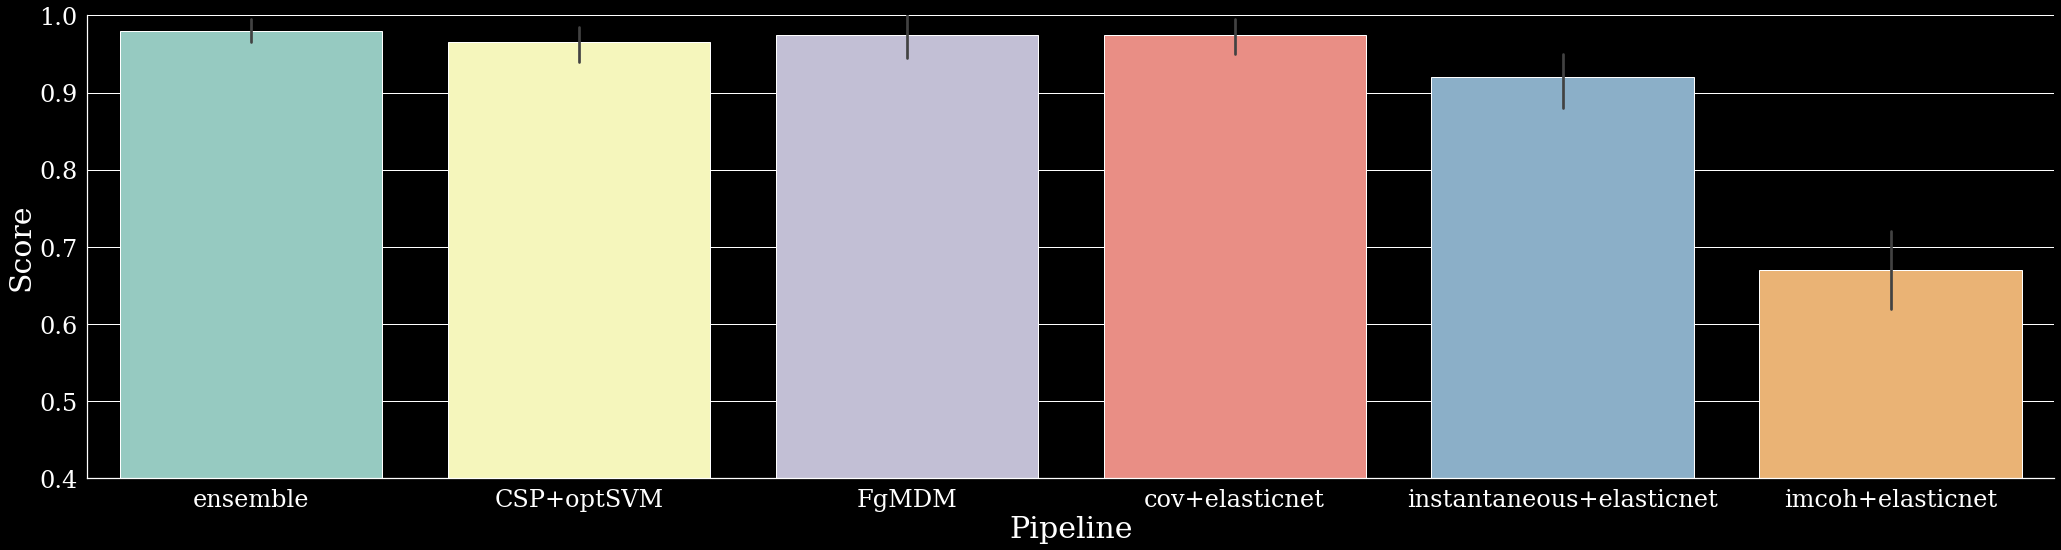

In [30]:
# plot comparison between pipelines
results_ensemble = pd.read_csv(
    "OptEnsemble.csv"
)
list_fc_ens=["ensemble","CSP+optSVM","FgMDM","cov+elasticnet","instantaneous+elasticnet","imcoh+elasticnet"]

# plots FC vs ens
plt.close("all")
plt.style.use("dark_background")
g = sns.catplot(
    data=results_ensemble,
    x="pipeline",
    y="score",
    kind="bar",
    #saturation=0.5,
    order=list_fc_ens,
    height=7,
    aspect=4,
)
plt.ylim((0.4, 1))
plt.xticks(range(len(results_ensemble["pipeline"].unique())),
           fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Pipeline", fontsize=30)
plt.ylabel("Score", fontsize=30)
plt.savefig(
    "Opt_Ensemble_Cho2017_bar_Group_fc_ens.pdf",
    dpi=300,
)
